<a href="https://colab.research.google.com/github/ankitkumarsingh1702/Duckworth-Lewis-Method/blob/main/assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
"""Assignment1_refactored.py

This is a Python script to optimize and plot the run-production function.
We will upload the dataset manually and use nonlinear regression to fit
the model Z(u, w) = Z0(w)[1 - exp{-L(u)/Z0(w)}].
"""

import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [41]:
# Define the run-production function: Z(u, w) = Z0(w) * [1 - exp(-L * u / Z0(w))]
def run_production_func(Z, L, u):
    return Z * (1 - np.exp(-L * u / Z))

In [42]:
# Clean up the dataset to use only valid and required data for the first innings
def data_cleanup(df):
    """
    This function removes irrelevant data and prepares the dataset
    for modeling by focusing on the first innings.
    """
    # Retain only first innings data
    df = df[df["Innings"] == 1].reset_index(drop=True)

    # Remove any rows with data errors flagged in the 'Error.In.Data' column
    df = df[df['Error.In.Data'] == 0]

    # Filter out invalid wickets data (must be between 1 and 10)
    df = df[(df['Wickets.in.Hand'] > 0) & (df['Wickets.in.Hand'] < 11)]

    # Keep only necessary columns for analysis
    df = df[['Match', 'Innings', 'Innings.Total.Runs', 'Total.Runs',
             'Over', 'Total.Overs', 'Wickets.in.Hand', 'Runs']]

    # Calculate remaining overs and runs to be scored
    df['Overs_left'] = df['Total.Overs'] - df['Over']
    df['Total.Runs'] = df.groupby('Match')['Runs'].cumsum()
    df['Runs_to_score'] = df['Innings.Total.Runs'] - df['Total.Runs']

    # Select only the necessary columns for the model
    return df[['Match', 'Innings', 'Wickets.in.Hand', 'Runs_to_score', 'Overs_left']]


In [43]:
# Define the loss function to compute squared error between predictions and actual runs left
def loss_sqr_error(params, args):
    """
    Computes the sum of squared errors between predicted and actual runs
    for the given model parameters.
    """
    total_loss = 0
    L = params[10]  # The last parameter is L (slope)
    innings, overs_left, runs_left, wickets_left = args

    # Calculate the squared error for each data point
    for i in range(len(wickets_left)):
        Z0 = params[wickets_left[i] - 1]  # Z0(w) for current wickets
        predicted_runs = run_production_func(Z0, L, overs_left[i])
        total_loss += (predicted_runs - runs_left[i]) ** 2

    return total_loss

In [44]:
# Optimize parameters using the specified method (e.g., L-BFGS-B)
def optimizer(method_name, innings, overs_left, runs_left, wickets_left):
    """
    Perform optimization to find the best-fit parameters for the run-production model.
    """
    # Initial parameter estimates for optimization
    initial_params = [20, 45, 75, 100, 125, 150, 175, 200, 225, 250, 10]

    # Use the minimize function from SciPy for optimization
    result = minimize(
        loss_sqr_error,
        initial_params,
        args=[innings, overs_left, runs_left, wickets_left],
        method=method_name
    )

    return result.x, result.fun  # Optimized parameters and loss

In [46]:
# Generate plots for the optimized parameters
def generate_plot(opt_params):
    """
    Plot the run-production functions using the optimized parameters.
    """
    plt.figure(figsize=(10, 7))
    plt.xlabel('Overs Left (u)')
    plt.ylabel('Resources Remaining (%)')
    plt.xticks(np.arange(0, 51, 5))
    plt.yticks(np.arange(0, 101, 10))

    # Calculate max resource for normalization
    max_resource = run_production_func(opt_params[9], opt_params[10], 50)
    overs = np.arange(0, 51)

    # Plot the resource curves for each parameter Z(w)
    for i in range(10):
        fraction = run_production_func(opt_params[i], opt_params[10], overs) / max_resource
        plt.plot(overs, 100 * fraction, label=f'Z[{i + 1}]')

    plt.legend()
    plt.show()

--------Starting optimization of parameters--------
Finished!
Total Squared Err Loss =  104680568.66885166
Total Squared Err Loss Normalized =  1563.54003179716
L = 10.894035729765946
Z1 = 12.426833221995633
Z2 = 27.58080841738734
Z3 = 51.60406941289368
Z4 = 79.48157518333426
Z5 = 105.14608775714508
Z6 = 138.4737036586519
Z7 = 169.57337110387746
Z8 = 207.62524470085447
Z9 = 239.26560162680957
Z10 = 284.256104158933


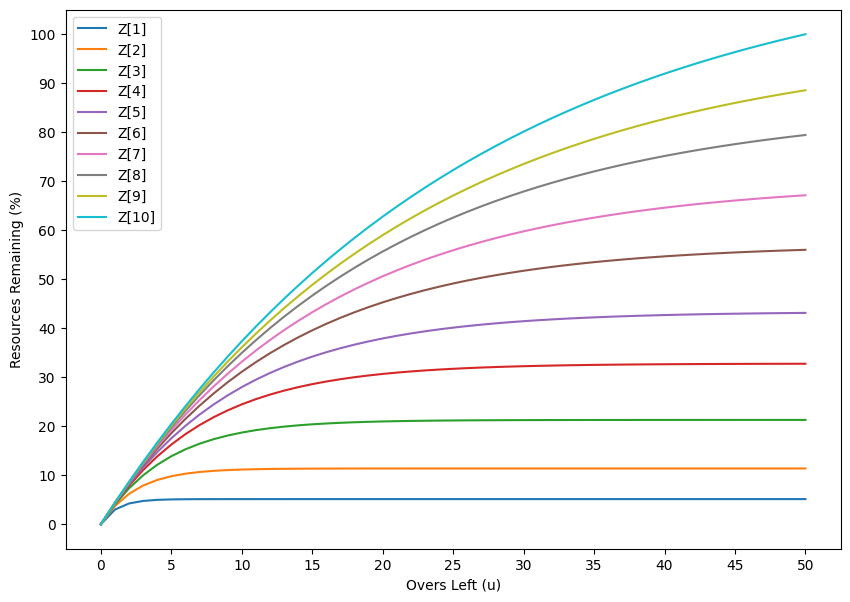

In [48]:
def main():
    data_path = "/content/data/"  # Updated path
    file_name = "04_cricket_1999to2011.csv"
    dataset = pd.read_csv(os.path.join(data_path, file_name))
    df = dataset.copy()
    df = data_cleanup(df)

    Remaining_overs = df['Overs_left'].values
    Wickets_in_Hand = df['Wickets.in.Hand'].values
    Runs_Remaining_cleaned = df['Runs_to_score'].values
    innings = df['Innings'].values

    print("--------Starting optimization of parameters--------")
    opt_params, loss_sqr_error = optimizer('L-BFGS-B', innings, Remaining_overs, Runs_Remaining_cleaned, Wickets_in_Hand)
    #Normalized square loss
    normalized_loss_sqr_error = loss_sqr_error/len(df)
    print("Finished!")

    print('Total Squared Err Loss = ', loss_sqr_error)
    print('Total Squared Err Loss Normalized = ', normalized_loss_sqr_error)
    print('L = ' + str(opt_params[10]))
    for i in range(10):
        print('Z' + str(i+1) + ' = ' + str(opt_params[i]))

    generate_plot(opt_params)

if __name__ == "__main__":
    main()